In [ ]:
!apt-get update
!apt-get install -y swig ffmpeg
!pip install gymnasium[box2d] stable-baselines3 shimmy moviepy matplotlib pandas

In [ ]:
import gymnasium as gym
import numpy as np
from stable_baselines3.common.monitor import Monitor

class LocomotionRewardWrapper(gym.Wrapper):
    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)

        hull_angle = obs[0]
        forward_vel = obs[2]
        joint_vel_penalty = 0.001 * np.sum(obs[6:14] ** 2)
        action_penalty = 0.0005 * np.sum(action ** 2)

        shaping = (
            1.5 * forward_vel
            - 0.8 * abs(hull_angle)
            - joint_vel_penalty
            - action_penalty
        )

        return obs, reward + shaping, terminated, truncated, info


def make_env():
    env = gym.make("BipedalWalker-v3")
    env = LocomotionRewardWrapper(env)
    env = Monitor(env)
    return env

In [ ]:
from stable_baselines3.common.vec_env import SubprocVecEnv, VecNormalize

N_ENVS = 8

env = SubprocVecEnv([make_env for _ in range(N_ENVS)])
env = VecNormalize(
    env,
    norm_obs=True,
    norm_reward=True,
    clip_obs=10.0,
    gamma=0.99
)


In [ ]:
import torch.nn as nn
from stable_baselines3 import PPO

policy_kwargs = dict(
    activation_fn=nn.Tanh,
    net_arch=dict(pi=[256, 256], vf=[256, 256])
)

model = PPO(
    "MlpPolicy",
    env,
    policy_kwargs=policy_kwargs,
    learning_rate=3e-4,
    n_steps=4096,
    batch_size=512,
    n_epochs=10,
    gamma=0.99,
    gae_lambda=0.95,
    ent_coef=0.01,        # HIGHER exploration
    clip_range=0.2,
    max_grad_norm=0.5,
    verbose=1
)


In [ ]:
model.learn(total_timesteps=1_000_000)

model.save("./models/walker_normal")
env.save("./models/vecnorm_normal.pkl")
env.close()


In [ ]:
def make_hardcore_env():
    env = gym.make("BipedalWalker-v3", hardcore=True)
    env = LocomotionRewardWrapper(env)
    env = Monitor(env)
    return env

env = SubprocVecEnv([make_hardcore_env for _ in range(N_ENVS)])
env = VecNormalize(
    env,
    norm_obs=True,
    norm_reward=True,
    clip_obs=10.0,
    gamma=0.99
)


In [ ]:
model = PPO.load(
    "./models/walker_normal",
    env=env,
    learning_rate=1e-4,   # slower adaptation
    ent_coef=0.005        # still exploratory
)


In [ ]:
model.learn(total_timesteps=2_000_000)

model.save("./models/walker_hardcore")
env.save("./models/vecnorm_hardcore.pkl")
env.close()


In [ ]:
from gymnasium.wrappers import RecordVideo
from stable_baselines3.common.vec_env import DummyVecEnv

def make_eval_env(hardcore=False):
    env = gym.make(
        "BipedalWalker-v3",
        hardcore=hardcore,
        render_mode="rgb_array"
    )
    env = RecordVideo(
        env,
        video_folder="./videos",
        episode_trigger=lambda x: True,
        name_prefix="eval"
    )
    return env

env = DummyVecEnv([lambda: make_eval_env(hardcore=True)])
env = VecNormalize.load("./models/vecnorm_hardcore.pkl", env)

env.training = False
env.norm_reward = False

model = PPO.load("./models/walker_hardcore", env=env)

obs = env.reset()
for _ in range(2000):
    action, _ = model.predict(obs, deterministic=True)
    obs, _, done, _ = env.step(action)
    if done:
        break

env.close()


In [ ]:
import glob
import base64
from pathlib import Path
from IPython.display import HTML, display

def show_latest_video(folder="./videos"):
    videos = glob.glob(f"{folder}/*.mp4")
    if not videos:
        print("No video files found.")
        return

    videos.sort(key=lambda x: Path(x).stat().st_mtime)
    path = videos[-1]

    mp4 = Path(path).read_bytes()
    b64 = base64.b64encode(mp4).decode()

    display(HTML(f"""
    <video width="640" controls>
      <source src="data:video/mp4;base64,{b64}" type="video/mp4">
    </video>
    """))


In [ ]:
def make_eval_env_normal():
    env = gym.make(
        "BipedalWalker-v3",
        render_mode="rgb_array"
    )
    env = RecordVideo(
        env,
        video_folder="./videos/normal",
        episode_trigger=lambda x: True,
        name_prefix="normal_eval"
    )
    return env

env = DummyVecEnv([make_eval_env_normal])
env = VecNormalize.load("./models/vecnorm_normal.pkl", env)
env.training = False
env.norm_reward = False

model = PPO.load("./models/walker_normal", env=env)

obs = env.reset()
for _ in range(2000):
    action, _ = model.predict(obs, deterministic=True)
    obs, _, done, _ = env.step(action)
    if done:
        break

env.close()

show_latest_video("./videos/normal")


In [ ]:
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
import imageio
import numpy as np
import os

# --- CONFIG ---
MODEL_PATH = "./models/walker_normal"
STATS_PATH = "./models/vecnorm_normal.pkl"
OUTPUT_VIDEO = "manual_debug_run.mp4"

# 1. Setup Env (No RecordVideo Wrapper this time)
env = DummyVecEnv([lambda: gym.make("BipedalWalker-v3", render_mode="rgb_array")])

# 2. Load Stats & Model
print("Loading Brain & Eyes...")
if os.path.exists(STATS_PATH):
    env = VecNormalize.load(STATS_PATH, env)
    env.training = False
    env.norm_reward = False
else:
    print("⚠️ WARNING: No stats file found!")

model = PPO.load(MODEL_PATH, env=env)

# 3. RUN & CAPTURE FRAMES
print("--- 🎥 Starting Manual Recording ---")
obs = env.reset()
frames = []
steps = 0

for i in range(1600): # Try for 32 seconds max
    frames.append(env.render()) # Capture the frame manually

    action, _ = model.predict(obs, deterministic=True)
    obs, _, done, _ = env.step(action)
    steps += 1

    if done:
        print(f"❌ Robot fell/finished at Step {steps} ({steps/50:.2f} seconds)")
        break

env.close()

# 4. SAVE VIDEO
print(f"Saving {len(frames)} frames to video...")
if len(frames) > 0:
    # Save at 50 FPS (Real-time speed for BipedalWalker)
    imageio.mimsave(OUTPUT_VIDEO, frames, fps=50)
    print("✅ Video Saved!")

    # 5. DISPLAY
    from IPython.display import HTML, display
    import base64
    from pathlib import Path

    mp4 = Path(OUTPUT_VIDEO).read_bytes()
    b64 = base64.b64encode(mp4).decode()
    display(HTML(f'''
    <h3>Run Duration: {steps/50:.2f} Seconds</h3>
    <video width="640" controls autoplay>
      <source src="data:video/mp4;base64,{b64}" type="video/mp4">
    </video>
    '''))
else:
    print("No frames captured.")

Loading Brain & Eyes...
--- 🎥 Starting Manual Recording ---


❌ Robot fell/finished at Step 1450 (29.00 seconds)
Saving 1450 frames to video...
✅ Video Saved!


In [ ]:
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
import imageio
import numpy as np
import os
import base64
from pathlib import Path
from IPython.display import HTML, display

# --- CONFIG ---
MODEL_PATH = "./models/walker_hardcore"
STATS_PATH = "./models/vecnorm_hardcore.pkl"
OUTPUT_VIDEO = "manual_hardcore_run.mp4"

# 1. Setup Hardcore Env (hardcore=True)
# We use a simple lambda to create the gym env on the fly
env = DummyVecEnv([lambda: gym.make("BipedalWalker-v3", hardcore=True, render_mode="rgb_array")])

# 2. Load Stats & Model
print("Loading Hardcore Brain...")
if os.path.exists(STATS_PATH):
    env = VecNormalize.load(STATS_PATH, env)
    env.training = False
    env.norm_reward = False
else:
    print("⚠️ WARNING: No hardcore stats found! This will be ugly.")

if os.path.exists(f"{MODEL_PATH}.zip"):
    model = PPO.load(MODEL_PATH, env=env)
else:
    print("❌ ERROR: Hardcore model file missing.")
    # Stop here to prevent crashing later
    raise FileNotFoundError("Run the Hardcore training cell first.")

# 3. RUN & CAPTURE FRAMES
print("--- 🎥 Starting Manual Hardcore Recording ---")
obs = env.reset()
frames = []
steps = 0

# Hardcore tracks are long, we allow up to 2000 steps
for i in range(2000):
    frames.append(env.render()) # Capture the frame

    action, _ = model.predict(obs, deterministic=True)
    obs, _, done, _ = env.step(action)
    steps += 1

    if done:
        print(f"❌ Robot fell/finished at Step {steps} ({steps/50:.2f} seconds)")
        break

env.close()

# 4. SAVE & DISPLAY
if len(frames) > 0:
    print(f"Saving {len(frames)} frames...")
    imageio.mimsave(OUTPUT_VIDEO, frames, fps=50)

    mp4 = Path(OUTPUT_VIDEO).read_bytes()
    b64 = base64.b64encode(mp4).decode()
    display(HTML(f'''
    <h3>Hardcore Run: {steps/50:.2f} Seconds</h3>
    <video width="640" controls autoplay>
      <source src="data:video/mp4;base64,{b64}" type="video/mp4">
    </video>
    '''))
else:
    print("No frames captured.")

Loading Hardcore Brain...
--- 🎥 Starting Manual Hardcore Recording ---


❌ Robot fell/finished at Step 1600 (32.00 seconds)
Saving 1600 frames...


In [ ]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import SubprocVecEnv, VecNormalize
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.utils import set_random_seed
import os
from google.colab import drive
drive.mount("/content/drive")

DRIVE_ROOT = "/content/drive/MyDrive/bipedal_walker_project"
LOG_ROOT = f"{DRIVE_ROOT}/logs"
MODEL_ROOT = f"{DRIVE_ROOT}/models"
VIDEO_ROOT = f"{DRIVE_ROOT}/videos"

os.makedirs(LOG_ROOT, exist_ok=True)
os.makedirs(MODEL_ROOT, exist_ok=True)
os.makedirs(VIDEO_ROOT, exist_ok=True)


class LocomotionRewardWrapper(gym.Wrapper):
    def __init__(
        self,
        env,
        use_velocity=True,
        use_angle=True,
        use_joint_penalty=True,
        use_action_penalty=True,
    ):
        super().__init__(env)
        self.use_velocity = use_velocity
        self.use_angle = use_angle
        self.use_joint_penalty = use_joint_penalty
        self.use_action_penalty = use_action_penalty

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)

        hull_angle = obs[0]
        forward_vel = obs[2]

        shaping = 0.0

        if self.use_velocity:
            shaping += 1.5 * forward_vel
        if self.use_angle:
            shaping -= 0.8 * abs(hull_angle)
        if self.use_joint_penalty:
            shaping -= 0.001 * np.sum(obs[6:14] ** 2)
        if self.use_action_penalty:
            shaping -= 0.0005 * np.sum(action ** 2)

        return obs, reward + shaping, terminated, truncated, info

def make_env(
    seed,
    reward_cfg,
    env_id="BipedalWalker-v3"
):
    def _init():
        env = gym.make(env_id)
        env = LocomotionRewardWrapper(env, **reward_cfg)
        env = Monitor(env)
        env.reset(seed=seed)
        return env
    return _init

def run_experiment(
    exp_name,
    reward_cfg,
    n_envs=8,
    total_timesteps=1_000_000,
    ent_coef=0.01,
    n_steps=4096,
    seed=0,
    env_id="BipedalWalker-v3"
):
    from stable_baselines3.common.utils import set_random_seed
    set_random_seed(seed)

    log_dir = f"{LOG_ROOT}/{exp_name}"
    model_dir = f"{MODEL_ROOT}/{exp_name}"

    os.makedirs(log_dir, exist_ok=True)
    os.makedirs(model_dir, exist_ok=True)

    env = SubprocVecEnv(
        [make_env(seed + i, reward_cfg, env_id) for i in range(n_envs)]
    )
    env = VecNormalize(
        env,
        norm_obs=True,
        norm_reward=True,
        clip_obs=10.0,
        gamma=0.99
    )

    policy_kwargs = dict(
        activation_fn=nn.Tanh,
        net_arch=dict(pi=[256, 256], vf=[256, 256])
    )

    model = PPO(
        "MlpPolicy",
        env,
        learning_rate=3e-4,
        n_steps=n_steps,
        batch_size=512,
        n_epochs=10,
        gamma=0.99,
        gae_lambda=0.95,
        ent_coef=ent_coef,
        clip_range=0.2,
        max_grad_norm=0.5,
        policy_kwargs=policy_kwargs,
        tensorboard_log=log_dir,
        verbose=1
    )

    model.learn(total_timesteps=total_timesteps)

    model.save(f"{model_dir}/ppo_model")
    env.save(f"{model_dir}/vecnorm.pkl")
    env.close()

reward_ablations = {
    "no_shaping": dict(
        use_velocity=False,
        use_angle=False,
        use_joint_penalty=False,
        use_action_penalty=False,
    ),
    "velocity_only": dict(
        use_velocity=True,
        use_angle=False,
        use_joint_penalty=False,
        use_action_penalty=False,
    ),
    "velocity_angle": dict(
        use_velocity=True,
        use_angle=True,
        use_joint_penalty=False,
        use_action_penalty=False,
    ),
    "full_shaping": dict(
        use_velocity=True,
        use_angle=True,
        use_joint_penalty=True,
        use_action_penalty=True,
    ),
}

for name, cfg in reward_ablations.items():
    run_experiment(
        exp_name=f"reward_{name}",
        reward_cfg=cfg,
        seed=0,
    )

for ent in [0.0, 0.01]:
    for steps in [2048, 4096]:
        run_experiment(
            exp_name=f"tune_ent{ent}_steps{steps}",
            reward_cfg=reward_ablations["full_shaping"],
            ent_coef=ent,
            n_steps=steps,
            seed=0,
        )

for n_envs in [1, 4, 8]:
    run_experiment(
        exp_name=f"vec_{n_envs}",
        reward_cfg=reward_ablations["full_shaping"],
        n_envs=n_envs,
        seed=0,
    )

run_experiment(
    exp_name="hardcore_full_shaping",
    reward_cfg=reward_ablations["full_shaping"],
    env_id="BipedalWalkerHardcore-v3",
    total_timesteps=3_000_000,
    seed=0,
)


In [15]:
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from gymnasium.wrappers import RecordVideo

def record_video(
    model_path,
    vecnorm_path,
    env_id,
    video_name,
    n_episodes=1
):
    env = gym.make(env_id, render_mode="rgb_array")
    env = RecordVideo(
        env,
        video_folder=VIDEO_ROOT,
        name_prefix=video_name,
        episode_trigger=lambda x: True
    )

    env = DummyVecEnv([lambda: env])
    env = VecNormalize.load(vecnorm_path, env)
    env.training = False
    env.norm_reward = False

    model = PPO.load(model_path, env=env)

    for _ in range(n_episodes):
        obs = env.reset()
        done = False
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, _, done, _ = env.step(action)

    env.close()


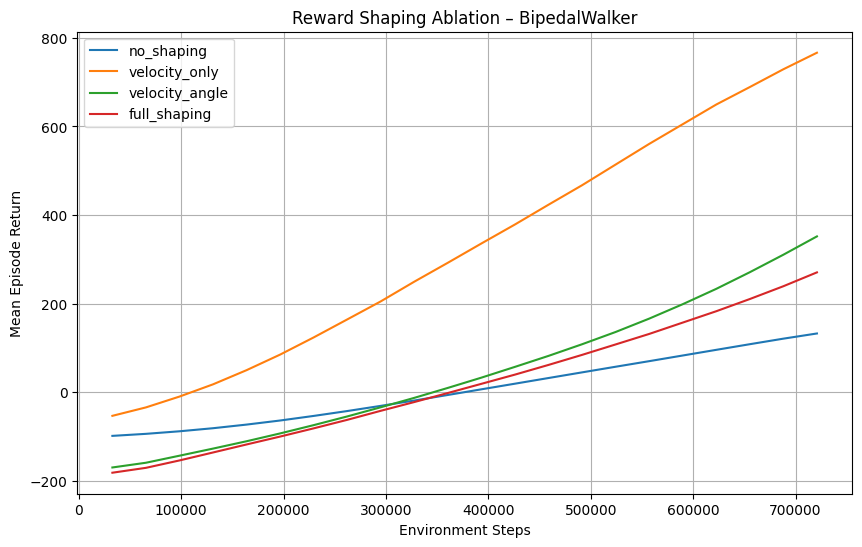

/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/evaluation.py:70: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Mean reward: 285.67 +/- 2.02


In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator

def load_tb_curve(log_dir, tag="rollout/ep_rew_mean"):
    """
    Returns timesteps, values for a given TensorBoard scalar.
    """
    event_files = []
    for root, _, files in os.walk(log_dir):
        for f in files:
            if "tfevents" in f:
                event_files.append(os.path.join(root, f))

    assert len(event_files) > 0, f"No event files in {log_dir}"

    ea = event_accumulator.EventAccumulator(
        event_files[0],
        size_guidance={"scalars": 0}
    )
    ea.Reload()

    scalars = ea.Scalars(tag)
    steps = np.array([s.step for s in scalars])
    values = np.array([s.value for s in scalars])

    return steps, values

reward_experiments = [
    "reward_no_shaping",
    "reward_velocity_only",
    "reward_velocity_angle",
    "reward_full_shaping",
]

plt.figure(figsize=(10, 6))

for exp in reward_experiments:
    log_dir = f"{LOG_ROOT}/{exp}"
    steps, rewards = load_tb_curve(log_dir)

    # Smooth for readability
    window = 10
    rewards_smooth = np.convolve(
        rewards, np.ones(window)/window, mode="valid"
    )

    plt.plot(
        steps[:len(rewards_smooth)],
        rewards_smooth,
        label=exp.replace("reward_", "")
    )

plt.xlabel("Environment Steps")
plt.ylabel("Mean Episode Return")
plt.title("Reward Shaping Ablation – BipedalWalker")
plt.legend()
plt.grid(True)
plt.show()


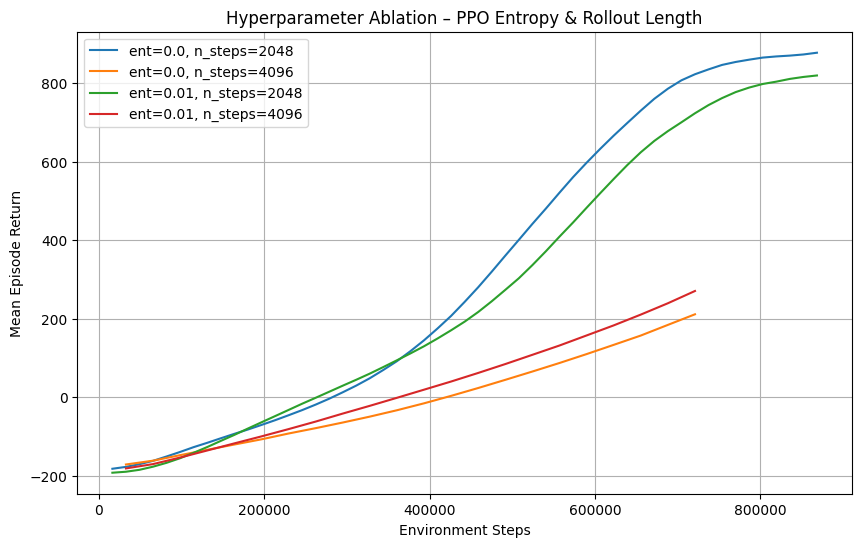

-114.98670115 0.21177422157389048


In [19]:
plt.figure(figsize=(10, 6))

for ent in [0.0, 0.01]:
    for stepsize in [2048, 4096]:
        exp = f"tune_ent{ent}_steps{stepsize}"
        log_dir = f"{LOG_ROOT}/{exp}"
        steps, rewards = load_tb_curve(log_dir)

        rewards_smooth = np.convolve(
            rewards, np.ones(10)/10, mode="valid"
        )

        plt.plot(
            steps[:len(rewards_smooth)],
            rewards_smooth,
            label=f"ent={ent}, n_steps={stepsize}"
        )

plt.xlabel("Environment Steps")
plt.ylabel("Mean Episode Return")
plt.title("Hyperparameter Ablation – PPO Entropy & Rollout Length")
plt.legend()
plt.grid(True)
plt.show()


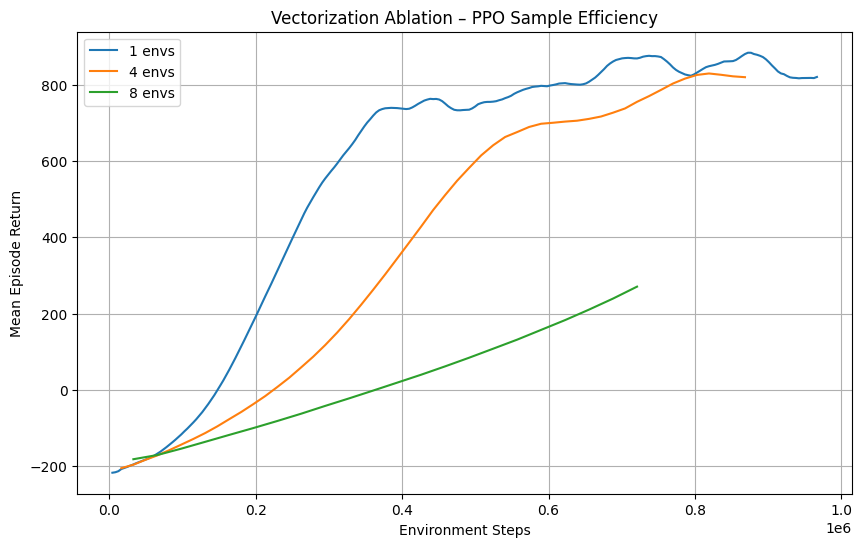

-114.91518520000002 0.23332009470266285


In [20]:
plt.figure(figsize=(10, 6))

for n in [1, 4, 8]:
    exp = f"vec_{n}"
    log_dir = f"{LOG_ROOT}/{exp}"
    steps, rewards = load_tb_curve(log_dir)

    rewards_smooth = np.convolve(
        rewards, np.ones(10)/10, mode="valid"
    )

    plt.plot(
        steps[:len(rewards_smooth)],
        rewards_smooth,
        label=f"{n} envs"
    )

plt.xlabel("Environment Steps")
plt.ylabel("Mean Episode Return")
plt.title("Vectorization Ablation – PPO Sample Efficiency")
plt.legend()
plt.grid(True)
plt.show()


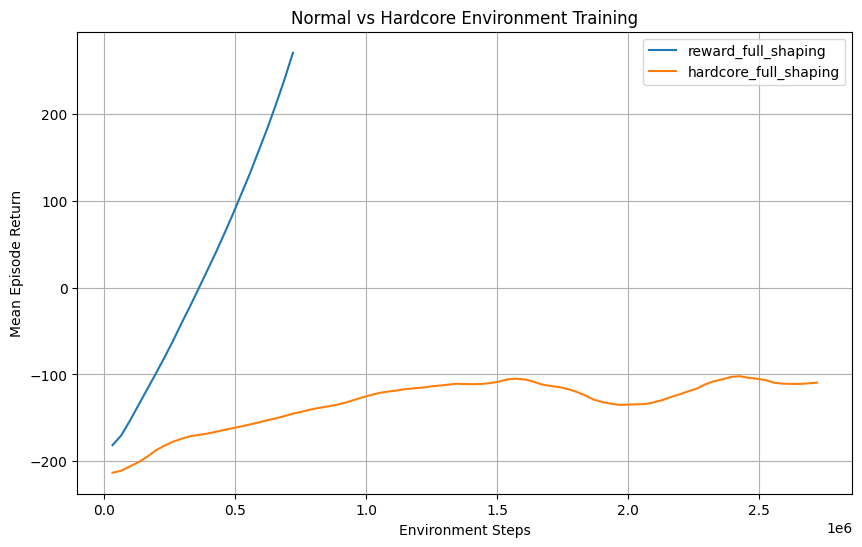

-114.94433115000001 0.23404900904260853


In [21]:
plt.figure(figsize=(10, 6))

for exp in ["reward_full_shaping", "hardcore_full_shaping"]:
    log_dir = f"{LOG_ROOT}/{exp}"
    steps, rewards = load_tb_curve(log_dir)

    rewards_smooth = np.convolve(
        rewards, np.ones(10)/10, mode="valid"
    )

    plt.plot(
        steps[:len(rewards_smooth)],
        rewards_smooth,
        label=exp
    )

plt.xlabel("Environment Steps")
plt.ylabel("Mean Episode Return")
plt.title("Normal vs Hardcore Environment Training")
plt.legend()
plt.grid(True)
plt.show()


In [11]:
def final_performance(log_dir, last_n=100):
    _, rewards = load_tb_curve(log_dir)
    return np.mean(rewards[-last_n:]), np.std(rewards[-last_n:])

for exp in reward_experiments:
    mean, std = final_performance(f"{LOG_ROOT}/{exp}")
    print(f"{exp:25s} | mean={mean:7.1f} ± {std:5.1f}")


reward_no_shaping         | mean=   11.2 ±  98.5
reward_velocity_only      | mean=  341.2 ± 346.7
reward_velocity_angle     | mean=   66.5 ± 228.8
reward_full_shaping       | mean=   32.1 ± 195.3


In [24]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
import os

MODEL_ROOT = "/content/drive/MyDrive/bipedal_walker_project/models"

def evaluate_experiment(exp_name, env_id="BipedalWalker-v3", n_eval_episodes=20):
    model_path = f"{MODEL_ROOT}/{exp_name}/ppo_model.zip"
    vecnorm_path = f"{MODEL_ROOT}/{exp_name}/vecnorm.pkl"

    env = gym.make(env_id)
    env = Monitor(env)
    env = DummyVecEnv([lambda: env])
    env = VecNormalize.load(vecnorm_path, env)
    env.training = False
    env.norm_reward = False

    model = PPO.load(model_path, env=env)

    mean, std = evaluate_policy(
        model,
        env,
        n_eval_episodes=n_eval_episodes,
        deterministic=True
    )

    env.close()
    return mean, std


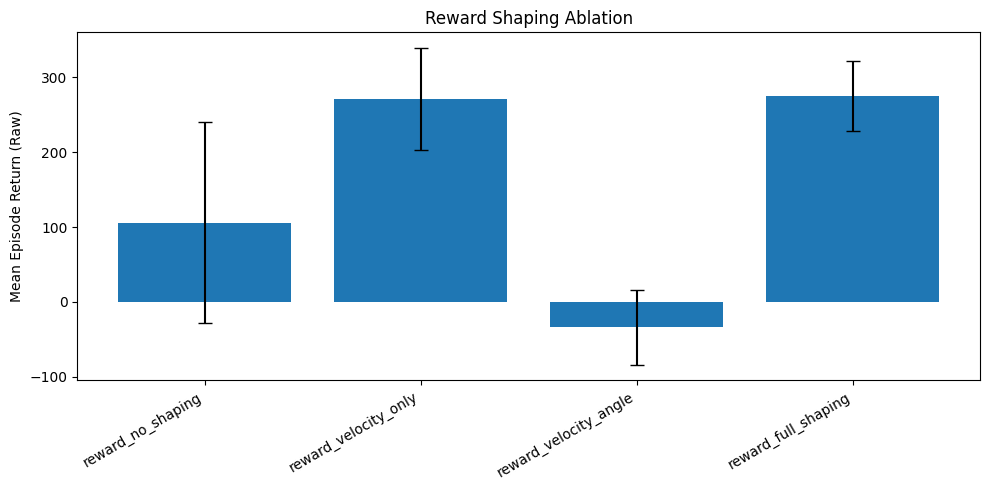

In [25]:
reward_exps = [
    "reward_no_shaping",
    "reward_velocity_only",
    "reward_velocity_angle",
    "reward_full_shaping",
]

reward_results = {
    exp: evaluate_experiment(exp)
    for exp in reward_exps
}

labels = reward_results.keys()
means = [reward_results[k][0] for k in labels]
stds = [reward_results[k][1] for k in labels]

plt.figure(figsize=(10,5))
plt.bar(labels, means, yerr=stds, capsize=5)
plt.xticks(rotation=30, ha="right")
plt.ylabel("Mean Episode Return (Raw)")
plt.title("Reward Shaping Ablation")
plt.tight_layout()
plt.show()


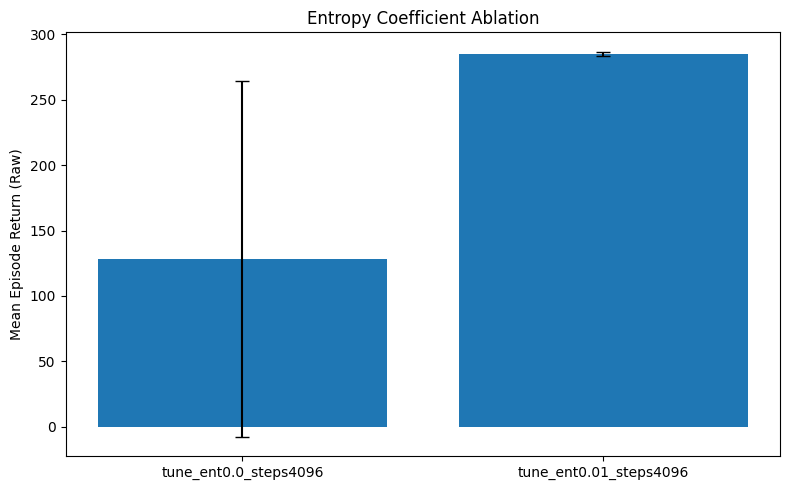

In [26]:
entropy_exps = [
    "tune_ent0.0_steps4096",
    "tune_ent0.01_steps4096",
]

entropy_results = {
    exp: evaluate_experiment(exp)
    for exp in entropy_exps
}

labels = entropy_results.keys()
means = [entropy_results[k][0] for k in labels]
stds = [entropy_results[k][1] for k in labels]

plt.figure(figsize=(8,5))
plt.bar(labels, means, yerr=stds, capsize=5)
plt.ylabel("Mean Episode Return (Raw)")
plt.title("Entropy Coefficient Ablation")
plt.tight_layout()
plt.show()


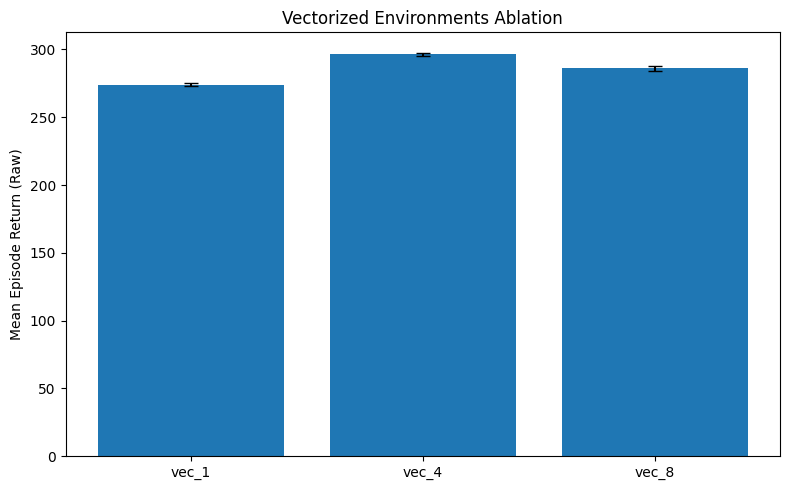

In [28]:
vec_exps = [
    "vec_1",
    "vec_4",
    "vec_8",
]

vec_results = {
    exp: evaluate_experiment(exp)
    for exp in vec_exps
}

labels = vec_results.keys()
means = [vec_results[k][0] for k in labels]
stds = [vec_results[k][1] for k in labels]

plt.figure(figsize=(8,5))
plt.bar(labels, means, yerr=stds, capsize=5)
plt.ylabel("Mean Episode Return (Raw)")
plt.title("Vectorized Environments Ablation")
plt.tight_layout()
plt.show()


Hardcore Full Shaping:
Mean return: -78.765867
Std: 20.770514231289614


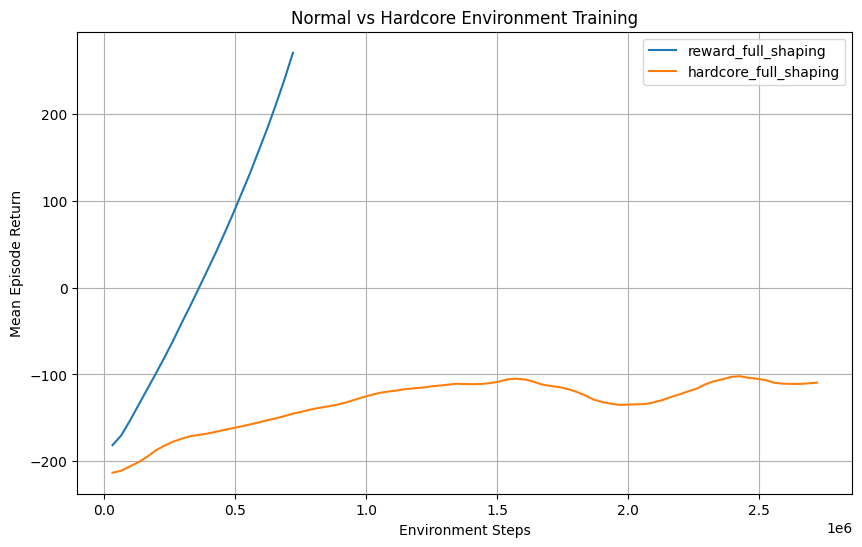

In [30]:
hardcore_mean, hardcore_std = evaluate_experiment(
    "hardcore_full_shaping",
    env_id="BipedalWalkerHardcore-v3",
    n_eval_episodes=10
)

print("Hardcore Full Shaping:")
print("Mean return:", hardcore_mean)
print("Std:", hardcore_std)

plt.figure(figsize=(10, 6))

for exp in ["reward_full_shaping", "hardcore_full_shaping"]:
    log_dir = f"{LOG_ROOT}/{exp}"
    steps, rewards = load_tb_curve(log_dir)

    rewards_smooth = np.convolve(
        rewards, np.ones(10)/10, mode="valid"
    )

    plt.plot(
        steps[:len(rewards_smooth)],
        rewards_smooth,
        label=exp
    )

plt.xlabel("Environment Steps")
plt.ylabel("Mean Episode Return")
plt.title("Normal vs Hardcore Environment Training")
plt.legend()
plt.grid(True)
plt.show()


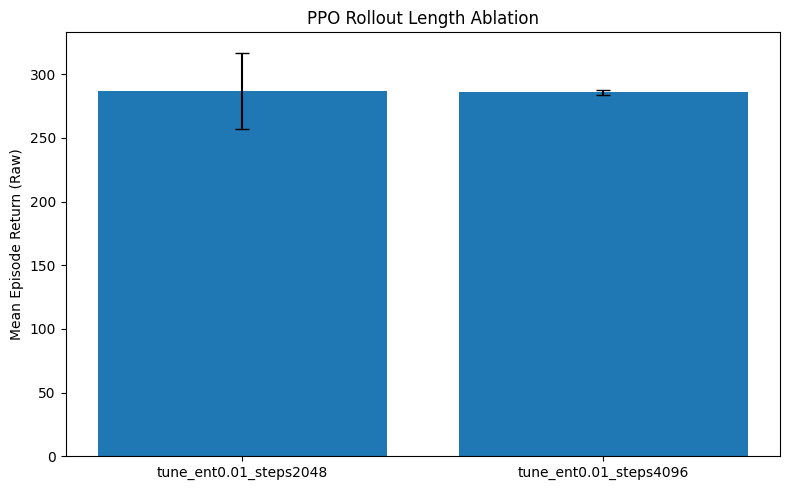

In [31]:
step_exps = [
    "tune_ent0.01_steps2048",
    "tune_ent0.01_steps4096",
]

step_results = {
    exp: evaluate_experiment(exp)
    for exp in step_exps
}

labels = step_results.keys()
means = [step_results[k][0] for k in labels]
stds = [step_results[k][1] for k in labels]

plt.figure(figsize=(8,5))
plt.bar(labels, means, yerr=stds, capsize=5)
plt.ylabel("Mean Episode Return (Raw)")
plt.title("PPO Rollout Length Ablation")
plt.tight_layout()
plt.show()

In [32]:
import os

# Get the number of threads (logical CPUs)
threads = os.cpu_count()

# Get the CPU model name (works on Linux/Colab)
try:
    model_name = os.popen("cat /proc/cpuinfo | grep 'model name' | head -1").read().strip().split(": ")[1]
except:
    model_name = "Intel Xeon (Generic)"

print(f"cpu_model: {model_name}")
print(f"logical_threads: {threads}")

cpu_model: Intel(R) Xeon(R) CPU @ 2.20GHz
logical_threads: 2
